# Super-Resolution Pipeline (AAI-521 Final Project)

This notebook implements a modular image super-resolution pipeline using the DIV2K dataset. It supports preprocessing, model inference, and evaluation, designed for reproducible deployment in Colab and GitHub workflows.


In [1]:
# Check the current working directory in the Colab environment.
# This helps confirm the starting path before mounting Drive or navigating to the project folder.
!pwd

/content


In [2]:
# Mount Google Drive to access shared project files and outputs
# Required for persistent storage and syncing with the fa25-aai521-group1 repository
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to the project root inside the mounted Drive
# Assumes the repo has been cloned to this location
%cd /content/fa25-aai521-group1

# Install required libraries for the super-resolution pipeline
# diffusers: Hugging Face library for generative models (e.g., latent diffusion)
# transformers: for model loading and tokenizer support (used internally)
# accelerate: for device placement and performance optimization
# safetensors: secure model serialization format (used when available)
!pip install diffusers transformers accelerate safetensors


Mounted at /content/drive
[Errno 2] No such file or directory: '/content/fa25-aai521-group1'
/content


In [3]:
# STEP 1: Define GitHub repository details
# These variables are used to construct the clone URL and configure Git identity
username = "gbauer-at-sandiego-edu"  # GitHub username (used for identity only)
repo = "fa25-aai521-group1"          # Repository name
org_or_user = "mr-kelsey"            # GitHub organization or user that owns the repo
branch = "week-4-person-b"           # Target working branch for this session

# STEP 2: Clean up any previous clone of the repo
# Ensures a fresh clone without residual files or branch conflicts
%cd /content
!rm -rf {repo}

# STEP 3: Clone the public repository via HTTPS
# No authentication required since the repo is public
!git clone https://github.com/{org_or_user}/{repo}.git
%cd {repo}

# STEP 4: Configure Git identity for local commits
# Required for branch creation and future pushes (if enabled)
!git config --global user.name "{username}"
!git config --global user.email "gbauer@sandiego.edu"

# STEP 5: Create and switch to a new working branch
# This isolates your changes and supports reproducible collaboration
!git checkout -b {branch}


/content
Cloning into 'fa25-aai521-group1'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 549 (delta 26), reused 42 (delta 19), pack-reused 493 (from 1)
Receiving objects: 100% (549/549), 1.08 GiB | 31.28 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (468/468), done.
/content/fa25-aai521-group1
Switched to a new branch 'week-4-person-b'


In [4]:
# Standard libraries for file handling and tensor operations
import os           # File system navigation and path management
import torch        # Core tensor library for GPU acceleration and model execution

# Image processing and visualization
from PIL import Image               # Image loading and manipulation
import matplotlib.pyplot as plt     # Visualization of image comparisons

# Hugging Face latent diffusion pipeline for 4× super-resolution
from diffusers import LDMSuperResolutionPipeline  # Pretrained model interface


In [5]:
def get_image_pairs(scale="x4"):
    """
    Loads paired low-resolution and high-resolution image paths from the DIV2K dataset.

    Assumes:
    - Low-res images are stored in 'data/scaled' and named with suffix like '_x4.png'
    - High-res ground truth images are stored in 'data/truth' and share the same base name
    - Only includes pairs where both low-res and high-res files exist

    Returns:
    - List of (low_res_path, high_res_path) tuples for valid image pairs
    """
    low_res_dir = "data/scaled"
    high_res_dir = "data/truth"
    pairs = []

    for fname in os.listdir(low_res_dir):
        if fname.endswith(f"_{scale}.png"):
            base = fname.split(f"_{scale}")[0]
            lr_path = os.path.join(low_res_dir, fname)
            hr_path = os.path.join(high_res_dir, f"{base}.png")
            if os.path.exists(hr_path):
                pairs.append((lr_path, hr_path))

    return pairs


In [6]:
# Load the pretrained latent diffusion model for 4× super-resolution from Hugging Face
pipe = LDMSuperResolutionPipeline.from_pretrained(
    "CompVis/ldm-super-resolution-4x-openimages",  # Model repository on Hugging Face
    torch_dtype=torch.float16,                     # Use half-precision for faster inference on GPU
    use_safetensors=False                          # Allow loading .bin weights (model does not provide .safetensors)
).to("cuda")                                       # Move model to GPU for acceleration


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
from PIL import Image

def run_ldm_inference(image_path):
    """
    Performs super-resolution inference using the pretrained latent diffusion model (LDM).

    Steps:
    - Loads the input image from the specified path.
    - Converts it to RGB format to ensure compatibility with the model.
    - Resizes it to 128×128 pixels, which is a strict input requirement for this LDM pipeline.
    - Passes the image through the model to generate a super-resolved output.

    Returns:
    - lr_img: the resized low-resolution input image (PIL.Image)
    - sr_img: the super-resolved output image generated by the model (PIL.Image)
    """
    lr_img = Image.open(image_path).convert("RGB").resize((128, 128))
    sr_img = pipe(lr_img).images[0]
    return lr_img, sr_img


In [8]:
import matplotlib.pyplot as plt

def show_comparison(lr_img, sr_img, hr_img):
    """
    Displays low-resolution input, super-resolved output, and high-resolution ground truth side by side.

    Parameters:
    - lr_img: PIL.Image, resized low-resolution input (128×128)
    - sr_img: PIL.Image, super-resolved output generated by the LDM pipeline
    - hr_img: PIL.Image, original high-resolution ground truth image

    Behavior:
    - Uses matplotlib to create a horizontal layout with three subplots.
    - Titles each image for clarity.
    - Removes axis ticks and labels for cleaner presentation.
    - Applies tight layout to avoid overlap and ensure consistent spacing.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(lr_img); axs[0].set_title("Low-Res Input")
    axs[1].imshow(sr_img); axs[1].set_title("Super-Res Output (LDM)")
    axs[2].imshow(hr_img); axs[2].set_title("High-Res Ground Truth")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

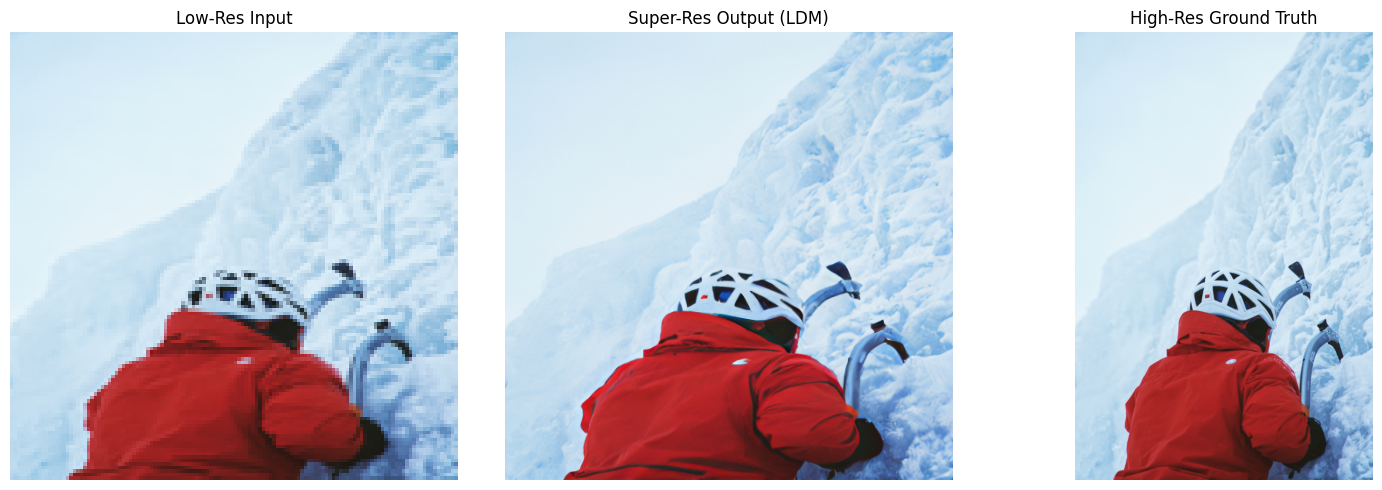

In [9]:
# Load one image pair from the dataset using the specified scale factor (e.g., "x4")
pairs = get_image_pairs("x4")
lr_path, hr_path = pairs[0]  # Select the first available pair

# Run super-resolution inference on the low-resolution image
lr_img, sr_img = run_ldm_inference(lr_path)

# Load the corresponding high-resolution ground truth image
hr_img = Image.open(hr_path).convert("RGB")

# Display all three images side by side for visual comparison
show_comparison(lr_img, sr_img, hr_img)


In [10]:
def run_batch_ldm(pairs, max_images=5):
    """
    Runs LDM super-resolution on a batch of image pairs.

    Parameters:
    - pairs: list of (low_res_path, high_res_path) tuples from get_image_pairs()
    - max_images: maximum number of pairs to process (default is 5)

    Returns:
    - results: list of (filename, lr_img, sr_img, hr_img) tuples
      where:
        - filename is the base name of the image
        - lr_img is the resized low-resolution input (PIL.Image)
        - sr_img is the super-resolved output (PIL.Image)
        - hr_img is the high-resolution ground truth (PIL.Image)
    """
    results = []
    for i, (lr_path, hr_path) in enumerate(pairs[:max_images]):
        base = os.path.basename(lr_path)
        print(f"[{i+1}] Processing {base}...")
        lr_img, sr_img = run_ldm_inference(lr_path)
        hr_img = Image.open(hr_path).convert("RGB")
        results.append((base, lr_img, sr_img, hr_img))
    return results


In [11]:
def show_batch_results(results):
    """
    Displays all batch results in a grid layout: Low-Res | Super-Res | High-Res.

    Parameters:
    - results: list of (filename, lr_img, sr_img, hr_img) tuples from run_batch_ldm()

    Behavior:
    - Iterates through each result and prints the filename.
    - Calls show_comparison() to display the three aligned images for each sample.
    """
    for base, lr, sr, hr in results:
        print(f"\n{base}")
        show_comparison(lr, sr, hr)


In [12]:
# Load image pairs from the dataset using the specified scale factor ("x4")
pairs = get_image_pairs("x4")

# Run super-resolution inference on a batch of image pairs (up to max_images)
batch_results = run_batch_ldm(pairs, max_images=5)

# Display each result: low-res input, super-res output, and high-res ground truth
show_batch_results(batch_results)


Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Image quality metrics from scikit-image
from skimage.metrics import peak_signal_noise_ratio as compute_psnr       # Measures pixel-level fidelity (higher is better)
from skimage.metrics import structural_similarity as compute_ssim         # Measures perceptual similarity (closer to 1 is better)

# Numerical array support for image conversion and metric computation
import numpy as np


In [14]:
def evaluate_pair(sr_img, hr_img):
    """
    Computes PSNR and SSIM between a super-resolved image and its high-resolution ground truth.

    Steps:
    - Resizes the super-resolved image to match the ground truth resolution (if needed).
    - Converts both images to NumPy arrays for metric computation.
    - Computes:
        - PSNR (Peak Signal-to-Noise Ratio): measures pixel-level fidelity (higher is better).
        - SSIM (Structural Similarity Index): measures perceptual similarity (closer to 1 is better).

    Parameters:
    - sr_img: PIL.Image, super-resolved output
    - hr_img: PIL.Image, high-resolution ground truth

    Returns:
    - psnr: float, peak signal-to-noise ratio
    - ssim: float, structural similarity index
    """
    sr_resized = sr_img.resize(hr_img.size)
    sr_np = np.array(sr_resized)
    hr_np = np.array(hr_img)

    psnr = compute_psnr(hr_np, sr_np, data_range=255)
    ssim = compute_ssim(hr_np, sr_np, channel_axis=2, data_range=255)
    return psnr, ssim


## PSNR and SSIM: Image Quality Metrics

**Peak Signal-to-Noise Ratio (PSNR)** and **Structural Similarity Index Measure (SSIM)** are widely used metrics for evaluating the quality of reconstructed or enhanced images against a reference (ground truth).

### PSNR: Pixel-Level Fidelity

PSNR quantifies the ratio between the maximum possible signal power and the power of noise affecting image fidelity. It is derived from the Mean Squared Error (MSE) and expressed in decibels (dB). Higher PSNR values typically indicate better image quality, especially in terms of pixel-level accuracy.

- **Typical Interpretation**:
  - **< 20 dB**: Poor quality, noticeable distortion
  - **20–30 dB**: Moderate quality, visible artifacts
  - **30–40 dB**: Good quality, minor differences
  - **> 40 dB**: High fidelity, nearly indistinguishable from ground truth

- **Limitations**: PSNR is sensitive to pixel-wise differences but does not account for perceptual factors like structure or texture.

### SSIM: Perceptual Similarity

SSIM evaluates image quality based on human visual perception. It compares luminance, contrast, and structural information between two images. SSIM values range from -1 to 1, where **1 indicates perfect similarity**.

- **Typical Interpretation**:
  - **< 0.5**: Low structural similarity, perceptually different
  - **0.5–0.8**: Moderate similarity, some perceptual differences
  - **0.8–0.95**: High similarity, visually close
  - **> 0.95**: Very high similarity, nearly indistinguishable

- **Strengths**: SSIM aligns more closely with human judgment than PSNR, especially for natural images and perceptual tasks.

### References (APA 7)

- Horé, A., & Ziou, D. (2010). Image quality metrics: PSNR vs. SSIM. *2010 20th International Conference on Pattern Recognition*, 2366–2369. https://doi.org/10.1109/ICPR.2010.579  
- Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. *IEEE Transactions on Image Processing*, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819861

In [15]:
import pandas as pd

def evaluate_batch(results):
    """
    Evaluates PSNR and SSIM for a batch of (filename, lr_img, sr_img, hr_img) tuples.

    Parameters:
    - results: list of tuples from run_batch_ldm(), each containing:
        (filename, low-res image, super-res image, high-res ground truth)

    Returns:
    - A pandas DataFrame with columns:
        - 'Filename': base filename of the image
        - 'PSNR': Peak Signal-to-Noise Ratio (rounded to 2 decimals)
        - 'SSIM': Structural Similarity Index (rounded to 4 decimals)
    """
    scores = []
    for base, _, sr, hr in results:
        psnr, ssim = evaluate_pair(sr, hr)
        scores.append({
            "Filename": base,
            "PSNR": round(psnr, 2),
            "SSIM": round(ssim, 4)
        })
    return pd.DataFrame(scores)


In [16]:
# Evaluate PSNR and SSIM for the batch of super-resolved images
score_df = evaluate_batch(batch_results)

# Display the first few rows of the score summary
score_df.head()


,Filename,PSNR,SSIM
0,0843_x4.png,28.26,0.8909
1,0724_x4.png,21.18,0.5090
2,0590_x4.png,24.25,0.7323
3,0733_x4.png,19.49,0.5696
4,0289_x4.png,22.74,0.6268


In [17]:
def save_sr_images(results, output_dir="outputs/superres"):
    """
    Saves super-resolved images to fa25-aai521-group1/outputs/superres/.

    Parameters:
    - results: list of (filename, lr_img, sr_img, hr_img) tuples
    - output_dir: target directory for saving super-resolved images

    Behavior:
    - Creates the output directory if it doesn't exist.
    - Saves each super-resolved image with a filename prefix 'sr_'.
    - Prints the full path of each saved image for confirmation.
    """
    os.makedirs(output_dir, exist_ok=True)
    for base, _, sr, _ in results:
        out_path = os.path.join(output_dir, f"sr_{base}")
        sr.save(out_path)
        print(f"Saved: {out_path}")


In [18]:
def save_scores_to_csv(score_df, output_path="outputs/superres/superres_scores.csv"):
    """
    Saves PSNR/SSIM scores to fa25-aai521-group1/outputs/superres/superres_scores.csv.

    Parameters:
    - score_df: pandas DataFrame containing evaluation scores
    - output_path: full path to the output CSV file

    Behavior:
    - Creates the output directory if it doesn't exist.
    - Writes the DataFrame to CSV without the index column.
    - Prints confirmation with the saved file path.
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    score_df.to_csv(output_path, index=False)
    print(f"Scores saved to: {output_path}")


In [19]:
import random

def run_superres_pipeline(scale="x4", max_images=5):
    """
    Unified pipeline: loads image pairs, runs LDM inference, evaluates, and exports results.

    Parameters:
    - scale: string, resolution suffix used to locate low-res images (e.g., "x4")
    - max_images: int, number of image pairs to process

    Workflow:
    1. Loads valid low-res and high-res image pairs from the dataset.
    2. Runs super-resolution inference using the latent diffusion model.
    3. Evaluates output quality using PSNR and SSIM metrics.
    4. Displays the evaluation summary.
    5. Saves super-resolved images and score table to disk.
    """
    print("Loading image pairs...")
    pairs = get_image_pairs(scale)
    random.shuffle(pairs)  # Shuffle to randomize selection

    print("Running batch inference...")
    results = run_batch_ldm(pairs, max_images=max_images)

    print("Evaluating results...")
    score_df = evaluate_batch(results)
    display(score_df)

    print("Saving outputs...")
    save_sr_images(results, output_dir="outputs/superres")
    save_scores_to_csv(score_df, output_path="outputs/superres/superres_scores.csv")

    print("Pipeline complete.")


In [ ]:
run_superres_pipeline(scale="x4", max_images=5)


Loading image pairs...
Running batch inference...
[1] Processing 0227_x4.png...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
!pwd

In [ ]:
# Safely copy the notebook into the repo directory
!cp "/content/drive/MyDrive/Colab Notebooks/superres_pipeline.ipynb" "/content/fa25-aai521-group1/notebooks/superres/superres_pipeline.ipynb"

In [ ]:
# Install GitHub CLI (if not already installed)
!which gh || apt install gh -y

# Authenticate using the token securely
!gh auth login --with-token < /content/drive/MyDrive/token.txt

# Confirm authentication status
!gh auth status


In [ ]:
# Navigate to the repo directory
%cd /content/fa25-aai521-group1/notebooks/superres

# Ensure Git uses GitHub CLI for credentials
!git config --global credential.helper '!gh auth git-credential'

# Stage and commit the updated notebook
!git add superres_pipeline.ipynb
!git add output/superres/
!git commit -m "Update superres_pipeline.ipynb from Colab" || echo "No changes to commit."

# Recreate and push the branch if it was deleted remotely
!git push --set-upstream origin week-4-person-b
